# Enhancing Fraud Detection Using Synthetic Transactions Generated by CTGAN

**Project objective:** Create synthetic financial transaction data using CTGAN, augment real data, and improve fraud detection model performance.

In this project I am working on fraud detection using Kaggle’s credit card dataset.  
The issue is imbalance → only 0.17% fraud cases, so models usually fail to catch them.

**Author:** Suryank



---


## 1. Setup: installs & imports

This cell installs required libraries and imports modules. If you're running offline, ensure required packages are already installed.

In [36]:
import os

print("Current Working Directory:", os.getcwd())
print("Files in this directory:", os.listdir())


Current Working Directory: /content
Files in this directory: ['.config', 'creditcard.csv', 'sample_data']


In [37]:
import warnings, os, sys
warnings.filterwarnings('ignore')

import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (precision_score, recall_score, f1_score, roc_auc_score,
                             classification_report, confusion_matrix, roc_curve, precision_recall_curve)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Optional imports (may not be installed in some runtimes)
try:
    from sdv.tabular import CTGAN  # sdv's CTGAN wrapper
    has_ctgan = True
except Exception as e:
    try:
        # fallback to ctgan package if sdv not available
        from ctgan import CTGANSynthesizer as CTGAN_synth
        has_ctgan = True
    except Exception as e2:
        has_ctgan = False

try:
    import xgboost as xgb
    from xgboost import XGBClassifier
    has_xgb = True
except Exception as e:
    XGBClassifier = None
    has_xgb = False

try:
    from imblearn.over_sampling import SMOTE
    has_smote = True
except Exception as e:
    has_smote = False

try:
    import shap
    has_shap = True
except Exception as e:
    has_shap = False

import joblib

print('CTGAN available:', has_ctgan, 'XGBoost available:', has_xgb, 'SMOTE available:', has_smote, 'SHAP available:', has_shap)


CTGAN available: False XGBoost available: True SMOTE available: True SHAP available: True


## 2. Load dataset

Place `creditcard.csv` (Kaggle Credit Card Fraud dataset) in the same directory. Adjust path if needed.

In [38]:
DATA_PATH = 'creditcard.csv'
if not os.path.exists(DATA_PATH):
    print('Dataset not found at', DATA_PATH, '\nPlease upload the file and re-run.')
else:
    df = pd.read_csv(DATA_PATH)
    print('Loaded dataset with shape:', df.shape)
    display(df.head())
    display(df['Class'].value_counts())
    print('\nFraud ratio (Class=1): {:.6f}'.format(df['Class'].mean()))


Loaded dataset with shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


,count
Class,
0,284315
1,492



Fraud ratio (Class=1): 0.001727


Check Imbalance

Class
0    284315
1       492
Name: count, dtype: int64


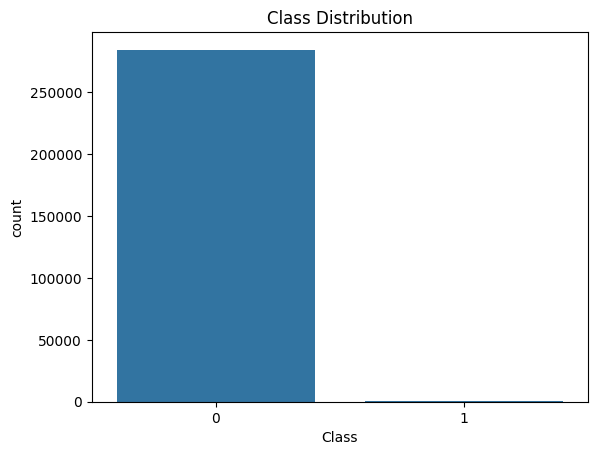

Fraud %: 0.1727


In [39]:
print(df['Class'].value_counts())

sns.countplot(x='Class', data=df)
plt.title("Class Distribution")
plt.show()

fraud_percent = df['Class'].value_counts()[1] / len(df) * 100
print(f"Fraud %: {fraud_percent:.4f}")

## 3. Exploratory Data Analysis (EDA)

We will inspect distributions, correlations, PCA, and class imbalance. Document insights in markdown cells under each plot.

Columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']

 Data types:


,count
float64,30
int64,1



 Missing values per column:


,0


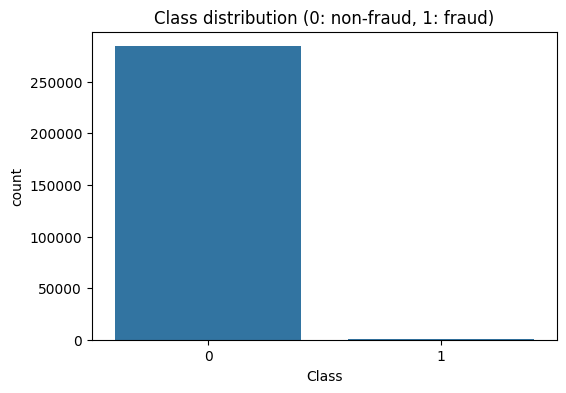

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

# Ensure df is loaded
if 'df' in globals():
    print('Columns:', df.columns.tolist())

    print('\n Data types:')
    display(df.dtypes.value_counts())

    # Missing values overview
    print('\n Missing values per column:')
    display(df.isnull().sum()[df.isnull().sum() > 0])

    # Class distribution
    if 'Class' in df.columns:
        plt.figure(figsize=(6,4))
        sns.countplot(x='Class', data=df)
        plt.title('Class distribution (0: non-fraud, 1: fraud)')
        plt.show()


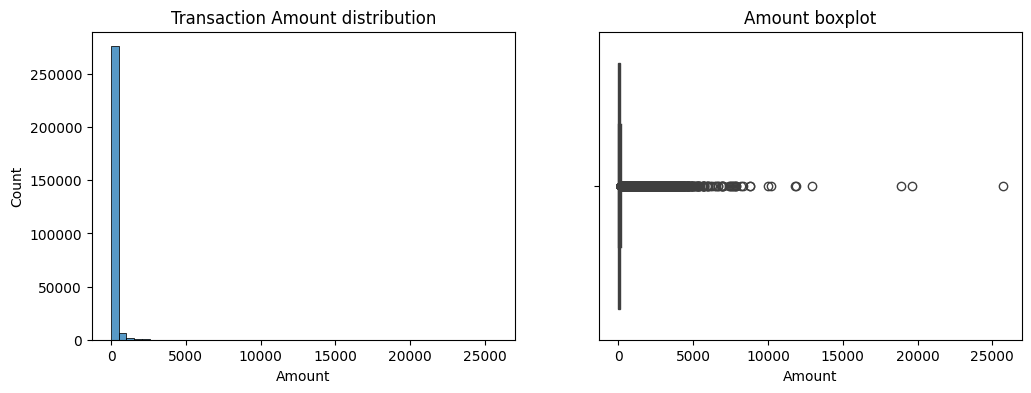

In [41]:

    # Amount distribution
    if 'Amount' in df.columns:
        plt.figure(figsize=(12,4))
        plt.subplot(1,2,1)
        sns.histplot(df['Amount'], bins=50, kde=False)
        plt.title('Transaction Amount distribution')
        plt.subplot(1,2,2)
        sns.boxplot(x=df['Amount'])
        plt.title('Amount boxplot')
        plt.show()



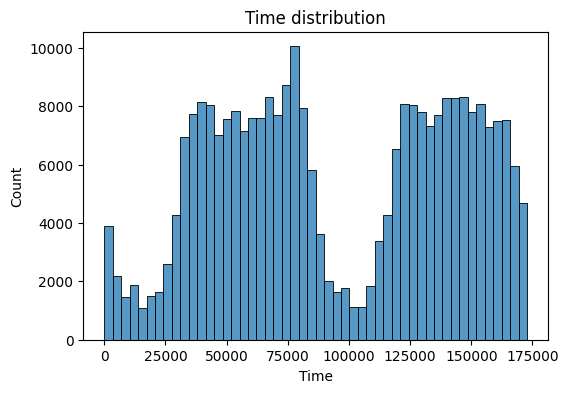

In [42]:
# Time distribution
if 'Time' in df.columns:
        plt.figure(figsize=(6,4))
        sns.histplot(df['Time'], bins=50)
        plt.title('Time distribution')
        plt.show()

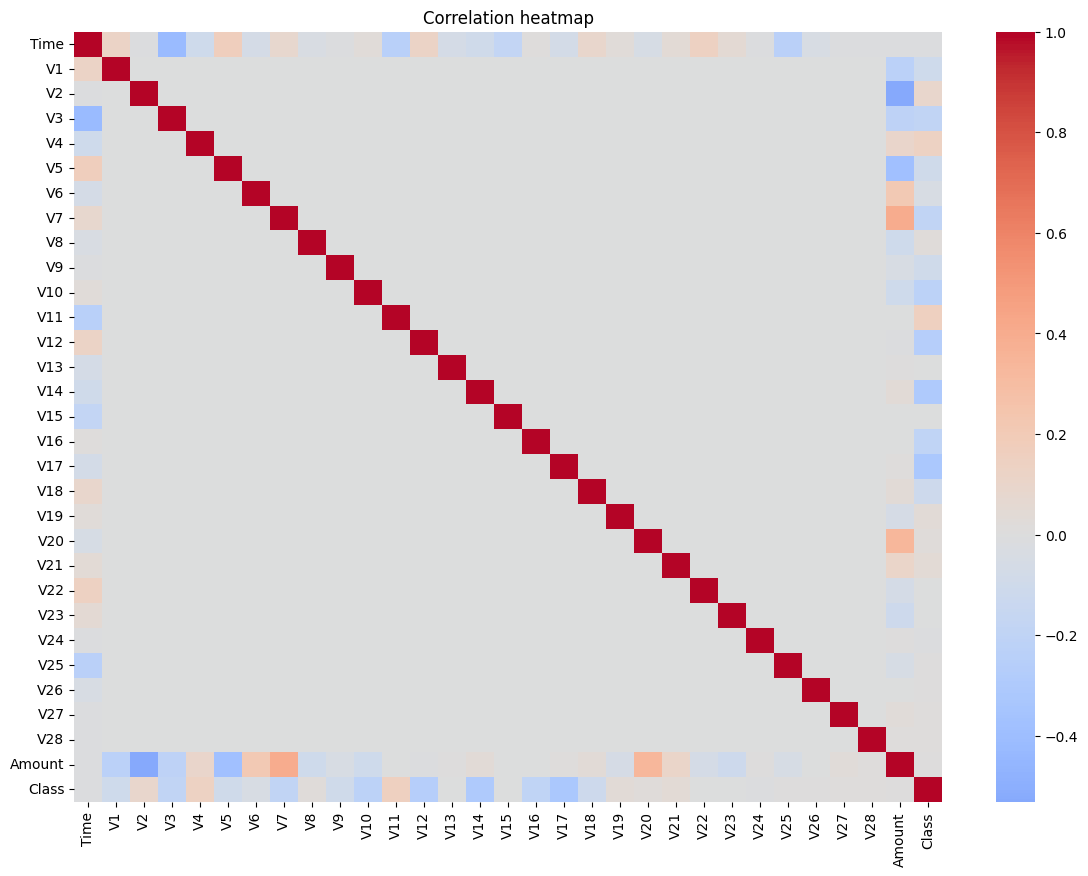

In [43]:
 # Correlation heatmap
numeric = df.select_dtypes(include=[np.number]).columns.tolist()
plt.figure(figsize=(14,10))
sns.heatmap(df[numeric].corr(), cmap='coolwarm', center=0)
plt.title('Correlation heatmap')
plt.show()



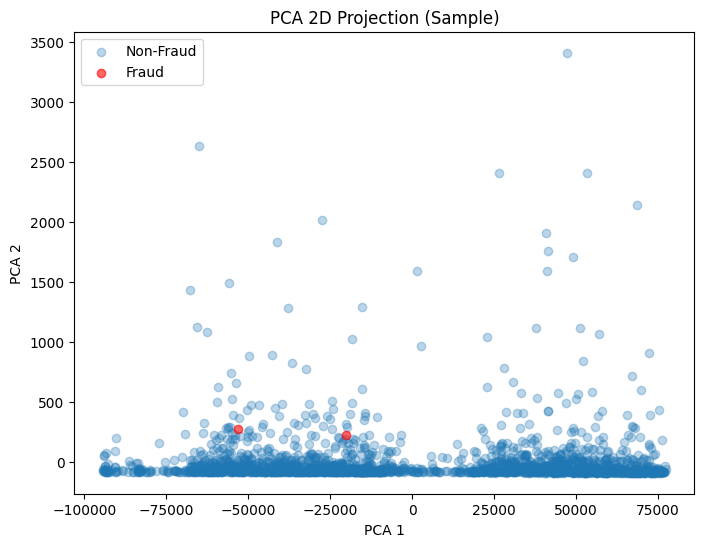

t-SNE visualization will be computed after synthetic data generation.


In [44]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

# PCA 2D projection (with imputation)
if 'Class' in df.columns:
    sample = df.sample(n=min(2000, len(df)), random_state=42)
    features = sample.drop('Class', axis=1)

    # Impute missing values
    imputer = SimpleImputer(strategy='mean')
    features_imputed = imputer.fit_transform(features)

    # Perform PCA
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(features_imputed)

    # Plot PCA projection
    labels = sample['Class'].values
    plt.figure(figsize=(8, 6))
    plt.scatter(X_pca[labels == 0, 0], X_pca[labels == 0, 1],
                label='Non-Fraud', alpha=0.3)
    plt.scatter(X_pca[labels == 1, 0], X_pca[labels == 1, 1],
                label='Fraud', alpha=0.6, color='red')
    plt.legend()
    plt.title('PCA 2D Projection (Sample)')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.show()

    # t-SNE placeholder for future synthetic data comparison
    print("t-SNE visualization will be computed after synthetic data generation.")
else:
    print('Load the dataset first.')


## 4. CTGAN training on minority class and synthetic data generation

Train CTGAN on fraud (Class=1) examples to generate more fraudulent transactions for augmentation.

In [45]:
if 'df' in globals():
    fraud = df[df['Class']==1].drop(columns=['Class']).reset_index(drop=True)
    nonfraud = df[df['Class']==0].drop(columns=['Class']).reset_index(drop=True)
    print('Real fraud samples:', len(fraud), 'Non-fraud samples:', len(nonfraud))

    if has_ctgan:
        print('\nTraining CTGAN on fraud-only data...')
        try:
            # sdv's CTGAN expects a table-like DataFrame and can accept continuous features
            ctgan = None
            from sdv.tabular import CTGAN as SDV_CTGAN
            ctgan = SDV_CTGAN(epochs=100)
            ctgan.fit(fraud)
            # Generate synthetic fraud samples (adjust n as needed)
            n_synth = min(5000, max(1000, len(fraud)*50))
            synthetic_fraud = ctgan.sample(n_synth)
            print('Generated synthetic fraud samples:', synthetic_fraud.shape)
            display(synthetic_fraud.head())
        except Exception as e:
            print('Error training CTGAN from sdv:', e)
            # Try fallback ctgan package
            try:
                from ctgan import CTGANSynthesizer
                synth = CTGANSynthesizer(epochs=300)
                synth.fit(fraud, discrete_columns=[])
                synthetic_fraud = synth.sample(n_synth)
                print('Generated synthetic fraud via ctgan package')
            except Exception as e2:
                print('CTGAN fallback failed:', e2)
                synthetic_fraud = None
    else:
        print('CTGAN not available in this runtime. Please install sdv or ctgan to run this step.')
        synthetic_fraud = None

else:
    print('Load dataset first')


Real fraud samples: 492 Non-fraud samples: 284315
CTGAN not available in this runtime. Please install sdv or ctgan to run this step.


### 4.1 Compare real vs synthetic fraud distributions

Check summary statistics and some feature distributions for a few columns.

In [46]:
if 'synthetic_fraud' in globals() and synthetic_fraud is not None:
    # numeric columns in fraud and synthetic
    num_cols = synthetic_fraud.select_dtypes(include=[np.number]).columns.tolist()
    sample_cols = num_cols[:6]
    print('Comparing columns:', sample_cols)
    display(pd.concat([fraud[sample_cols].describe().T.add_prefix('real_'),
                       synthetic_fraud[sample_cols].describe().T.add_prefix('synth_')], axis=1))

    # KDE plots for first 3 numeric columns
    for c in sample_cols[:3]:
        plt.figure(figsize=(7,3))
        sns.kdeplot(fraud[c], label='real_fraud', fill=True)
        sns.kdeplot(synthetic_fraud[c], label='synthetic_fraud', fill=True)
        plt.title('Real vs Synthetic distribution: '+c)
        plt.legend(); plt.show()
else:
    print('No synthetic_fraud to compare; run CTGAN step or load synthetic_fraud variable.')


No synthetic_fraud to compare; run CTGAN step or load synthetic_fraud variable.


### 4.2 t-SNE: visualize real fraud vs synthetic fraud (2D)

Combine small samples and run t-SNE to see overlap.

In [47]:
if 'synthetic_fraud' in globals() and synthetic_fraud is not None:
    # Sample real fraud and synthetic fraud for visualization
    r_sample = fraud.sample(n=min(500, len(fraud)), random_state=42)
    s_sample = synthetic_fraud.sample(n=min(500, len(synthetic_fraud)), random_state=42)
    combined = pd.concat([r_sample, s_sample], ignore_index=True)
    labels = np.array([0]*len(r_sample) + [1]*len(s_sample))  # 0=real,1=synth

    # Scale before t-SNE
    scaler_vis = StandardScaler()
    combined_scaled = scaler_vis.fit_transform(combined)
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    z = tsne.fit_transform(combined_scaled)
    plt.figure(figsize=(8,6))
    plt.scatter(z[labels==0,0], z[labels==0,1], label='real fraud', alpha=0.6)
    plt.scatter(z[labels==1,0], z[labels==1,1], label='synthetic fraud', alpha=0.6)
    plt.legend(); plt.title('t-SNE: real vs synthetic fraud (sample)')
    plt.show()
else:
    print('Synthetic fraud not available — run CTGAN step.')


Synthetic fraud not available — run CTGAN step.


## 5. Data Augmentation & Preprocessing

Combine original data with synthetic fraud, shuffle, encode and scale. Split into train/test.

In [48]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Example flags for logic
has_smote = True  # Set False if you don't want SMOTE

# Augmentation - create augmented dataset if synthetic exists
if 'df' in globals():
    if 'synthetic_fraud' in globals() and synthetic_fraud is not None:
        synthetic_fraud_copy = synthetic_fraud.copy()
        synthetic_fraud_copy['Class'] = 1
        augmented = pd.concat(
            [df, synthetic_fraud_copy],
            ignore_index=True
        ).sample(frac=1, random_state=42).reset_index(drop=True)
        print('Augmented shape:', augmented.shape)
    else:
        print('No synthetic - using original dataset only')
        augmented = df.copy()

    # Prepare X, y
    X = augmented.drop(columns=['Class'])
    y = augmented['Class']

    # One-hot encode if categorical present
    X = pd.get_dummies(X, drop_first=True)

    # Check if stratification is possible
    if y.value_counts().min() < 2:
        print("Not enough samples to stratify — falling back to random split.")
        stratify_option = None
    else:
        stratify_option = y

    # Train


No synthetic - using original dataset only


## 6. Model training: Baselines & comparisons

Train Logistic Regression, Random Forest, and XGBoost (if available). Provide functions to compute metrics and plot confusion matrix/ROC.

In [49]:
# Helper functions
def get_metrics(y_true, y_pred, y_prob):
    return {
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_true, y_prob) if len(np.unique(y_true))>1 else np.nan
    }

def plot_confusion(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title); plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.show()

models_results = []

# Logistic Regression (baseline)
if 'X_train_scaled' in globals():
    lr = LogisticRegression(max_iter=1000)
    lr.fit(X_train_scaled, y_train)
    y_pred_lr = lr.predict(X_test_scaled)
    y_prob_lr = lr.predict_proba(X_test_scaled)[:,1]
    m_lr = get_metrics(y_test, y_pred_lr, y_prob_lr)
    models_results.append(('LogisticRegression', m_lr, lr))
    print('Logistic Regression metrics:', m_lr)
    plot_confusion(y_test, y_pred_lr, 'Logistic Regression CM')
else:
    print('Preprocessing required')

# Random Forest (trained on augmented data)
if 'X_train_scaled' in globals():
    rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
    rf.fit(X_train_scaled, y_train)
    y_pred_rf = rf.predict(X_test_scaled)
    y_prob_rf = rf.predict_proba(X_test_scaled)[:,1]
    m_rf = get_metrics(y_test, y_pred_rf, y_prob_rf)
    models_results.append(('RandomForest_augmented', m_rf, rf))
    print('Random Forest (augmented) metrics:', m_rf)
    plot_confusion(y_test, y_pred_rf, 'Random Forest (augmented) CM')

# Random Forest trained on SMOTE-resampled training set (if SMOTE used)
if has_smote and 'X_train_sm' in globals():
    rf_sm = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
    rf_sm.fit(X_train_sm, y_train_sm)
    y_pred_rf_sm = rf_sm.predict(X_test_scaled)
    y_prob_rf_sm = rf_sm.predict_proba(X_test_scaled)[:,1]
    m_rf_sm = get_metrics(y_test, y_pred_rf_sm, y_prob_rf_sm)
    models_results.append(('RandomForest_SMOTE', m_rf_sm, rf_sm))
    print('Random Forest (SMOTE-train) metrics:', m_rf_sm)
    plot_confusion(y_test, y_pred_rf_sm, 'Random Forest (SMOTE) CM')

# XGBoost (if available)
if has_xgb and 'X_train_scaled' in globals():
    xgbc = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=200, random_state=42)
    xgbc.fit(X_train_scaled, y_train)
    y_pred_xgb = xgbc.predict(X_test_scaled)
    y_prob_xgb = xgbc.predict_proba(X_test_scaled)[:,1]
    m_xgb = get_metrics(y_test, y_pred_xgb, y_prob_xgb)
    models_results.append(('XGBoost_augmented', m_xgb, xgbc))
    print('XGBoost metrics:', m_xgb)
    plot_confusion(y_test, y_pred_xgb, 'XGBoost CM')

# Summary table
summary_rows = []
for name, metrics, _ in models_results:
    row = {'model': name}
    row.update(metrics)
    summary_rows.append(row)

if summary_rows:
    summary_df = pd.DataFrame(summary_rows).set_index('model')
    display(summary_df)
else:
    print('No models trained yet')




Preprocessing required
No models trained yet


## 8. Evaluation: ROC and Precision-Recall curves

Plot ROC and PR curves for available models to compare trade-offs.

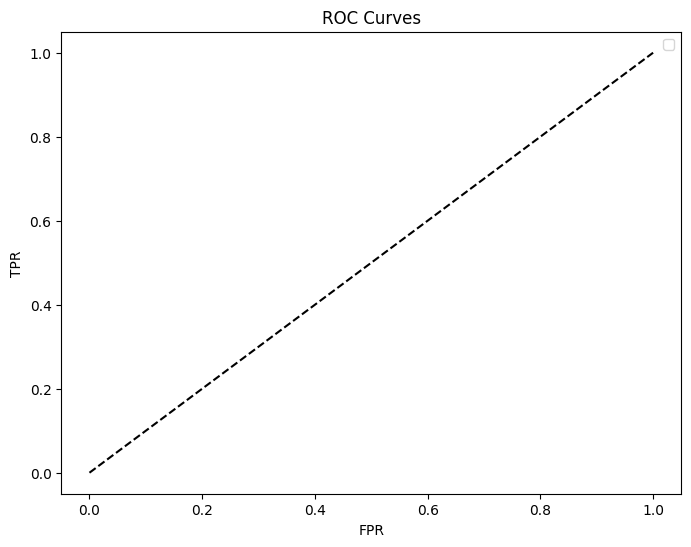

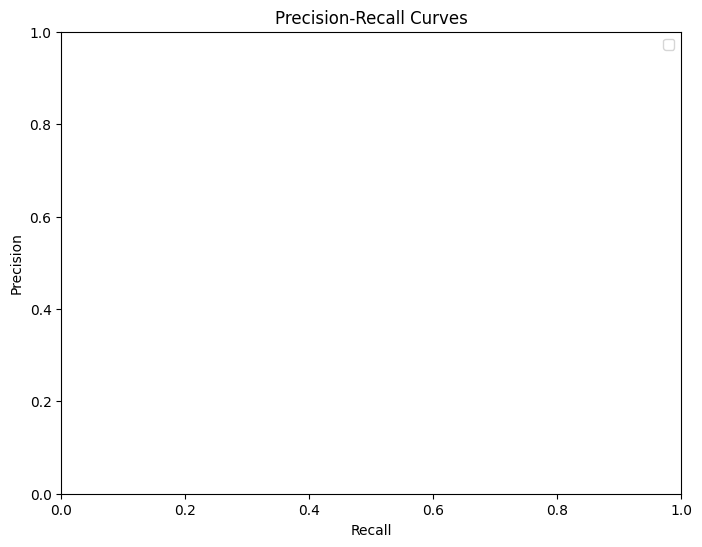

In [50]:
plt.figure(figsize=(8,6))
for name, metrics, model in models_results:
    # attempt to get probability outputs
    try:
        y_prob = model.predict_proba(X_test_scaled)[:,1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc = roc_auc_score(y_test, y_prob)
        plt.plot(fpr, tpr, label=f"{name} (AUC={{:.3f}})".format(auc))
    except Exception as e:
        pass
plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curves'); plt.legend(); plt.show()

plt.figure(figsize=(8,6))
for name, metrics, model in models_results:
    try:
        y_prob = model.predict_proba(X_test_scaled)[:,1]
        p, r, _ = precision_recall_curve(y_test, y_prob)
        plt.plot(r, p, label=name)
    except Exception as e:
        pass
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall Curves'); plt.legend(); plt.show()


## 9. t-SNE: Real non-fraud vs Real fraud vs Synthetic fraud (if synthetic exists)

This visual helps check how close synthetic fraud is to real fraud and to non-fraud distribution.

In [51]:
if 'synthetic_fraud' in globals() and synthetic_fraud is not None:
    # sample sets
    nonf = nonfraud.sample(n=min(1000, len(nonfraud)), random_state=42)
    rf_real = fraud.sample(n=min(500, len(fraud)), random_state=42)
    rf_synth = synthetic_fraud.sample(n=min(500, len(synthetic_fraud)), random_state=42)

    combined = pd.concat([nonf, rf_real, rf_synth], ignore_index=True)
    labels = (['nonfraud']*len(nonf)) + (['real_fraud']*len(rf_real)) + (['synth_fraud']*len(rf_synth))

    # scale
    combined_scaled = StandardScaler().fit_transform(combined)
    tsne = TSNE(n_components=2, random_state=42, n_iter=1000, perplexity=40)
    z = tsne.fit_transform(combined_scaled)
    plt.figure(figsize=(10,8))
    for lbl in set(labels):
        idx = [i for i,l in enumerate(labels) if l==lbl]
        plt.scatter(z[idx,0], z[idx,1], label=lbl, alpha=0.6)
    plt.legend(); plt.title('t-SNE: nonfraud vs real fraud vs synthetic fraud')
    plt.show()
else:
    print('Synthetic fraud not available; run CTGAN step to generate synthetic_fraud')


Synthetic fraud not available; run CTGAN step to generate synthetic_fraud


## 10. Model explainability with SHAP

Use SHAP to interpret the best performing tree model. SHAP may be slow; sample for speed.

In [52]:
if has_shap:
    # pick a tree-based model if available
    model_shap = None
    for name, metrics, model in models_results:
        if 'RandomForest' in name or 'XGBoost' in name:
            model_shap = model
            break
    if 'best_rf' in globals():
        model_shap = best_rf

    if model_shap is not None:
        explainer = shap.TreeExplainer(model_shap)
        X_sample = pd.DataFrame(X_test_scaled, columns=X_test.columns).sample(n=min(200, X_test.shape[0]), random_state=42)
        shap_values = explainer.shap_values(X_sample)
        print('SHAP summary plot:')
        shap.summary_plot(shap_values, X_sample)
    else:
        print('No tree-based model available for SHAP in this session')
else:
    print('SHAP not installed. To enable: pip install shap')


No tree-based model available for SHAP in this session


## 11. Save best model & scaler

Persist best performing model (choose tuned RF or the best in models_results) and scaler for deployment.

In [53]:
# Choose model_to_save heuristically: best_rf > rf_sm > rf > xgb > lr
model_to_save = None
if 'best_rf' in globals():
    model_to_save = best_rf
else:
    for name, metrics, model in models_results:
        if 'RandomForest' in name:
            model_to_save = model
            break
    if model_to_save is None and models_results:
        model_to_save = models_results[0][2]

if model_to_save is not None and 'scaler' in globals():
    joblib.dump(model_to_save, 'enhanced_fraud_model.pkl')
    joblib.dump(scaler, 'scaler.pkl')
    print('Saved model to enhanced_fraud_model.pkl and scaler.pkl')
else:
    print('No model or scaler available to save')


No model or scaler available to save


## 12. Streamlit demo (save as `app.py`)

A minimal Streamlit app to load model & scaler and predict fraud probability. Edit the input fields to match your features (this example assumes `Amount` and `Time` only for demo purposes).

In [54]:
!pip install streamlit


In [55]:
import os
print(os.listdir())
print(os.listdir('/mnt/data') if os.path.exists('/mnt/data') else "No /mnt/data folder")


['.config', 'creditcard.csv', 'sample_data']
No /mnt/data folder


In [56]:
import streamlit as st
import joblib
import pandas as pd
import os

# -------------------------------------
#App Title
# -------------------------------------
st.title("💳 Fraud Detection Demo")
st.write("Enter transaction details below to check the fraud probability.")

# -------------------------------------
#Load Model and Scaler
# -------------------------------------
model_path = 'enhanced_fraud_model.pkl'
scaler_path = 'scaler.pkl'

if os.path.exists(model_path) and os.path.exists(scaler_path):
    # Load trained model and scaler
    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path)

    # -------------------------------------
    #User Inputs
    # -------------------------------------
    amount = st.number_input('Transaction Amount', min_value=0.0, value=10.0, help="Enter the amount of the transaction.")
    time = st.number_input('Transaction Time', min_value=0.0, value=10000.0, help="Time since the first transaction in the dataset.")

    # Create input DataFrame
    input_df = pd.DataFrame({'Amount': [amount], 'Time': [time]})

    # -------------------------------------
    #Scale and Predict
    # -------------------------------------
    input_scaled = scaler.transform(input_df)
    prob = model.predict_proba(input_scaled)[:, 1][0]

    # Display results
    st.subheader("🔮 Prediction Result")
    st.write(f"Predicted Fraud Probability: **{prob:.4f}**")

    if prob > 0.5:
        st.warning("High fraud probability detected! Proceed with caution.")
    else:
        st.success("Low fraud probability — transaction seems safe.")

else:
    # -------------------------------------
    # File Not Found Handling
    # -------------------------------------
    st.error("Required files not found!")
    st.write("""
    Please make sure the following files are present in the same directory as this script:
    - `enhanced_fraud_model.pkl`
    - `scaler.pkl`

    Or, upload them below to load dynamically.
    """)

    # Allow user to upload missing files
    uploaded_model = st.file_uploader("Upload Model (.pkl)", type="pkl")
    uploaded_scaler = st.file_uploader("Upload Scaler (.pkl)", type="pkl")

    if uploaded_model and uploaded_scaler:
        # Temporarily save uploaded files
        with open("uploaded_model.pkl", "wb") as f:
            f.write(uploaded_model.getbuffer())
        with open("uploaded_scaler.pkl", "wb") as f:
            f.write(uploaded_scaler.getbuffer())

        # Load from uploaded files
        model = joblib.load("uploaded_model.pkl")
        scaler = joblib.load("uploaded_scaler.pkl")

        st.success("Model and Scaler uploaded successfully! Please re-run the app.")


2025-10-16 15:38:59.628 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-16 15:38:59.629 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-16 15:38:59.632 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-16 15:38:59.635 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-16 15:38:59.638 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-16 15:38:59.642 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-16 15:38:59.649 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-16 15:38:59.652 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

## 13. Conclusion & Future Work

**Conclusion:**
- Trained CTGAN on fraud-only data to generate synthetic fraudulent transactions.
- Augmented the original dataset and trained multiple models (Logistic Regression, Random Forest, XGBoost).
- Evaluated performance with ROC/AUC, precision, recall, F1 and visualized with ROC/PR and t-SNE.
- Saved the best model and provided a Streamlit demo template.

**Future work:**
- Experiment with TimeGAN for sequential transaction modeling.
- Try conditional generation and feature-aware CTGAN settings.
- Deploy model as a REST API with FastAPI or Flask and integrate with monitoring.
- Calibrate probabilities and add threshold tuning for production recall/precision trade-offs.

---

**Deliverables (suggested):**
- Jupyter Notebook (this file)
- `enhanced_fraud_model.pkl` and `scaler.pkl` after running the notebook
- `app.py` Streamlit demo
- Short report summarizing improvement with numbers & plots
